### Example 7: A more notorious non-linear problem
Part of ESE 156 Remote Sensing Class;
Christian Frankenberg
__________

So far, we have ignored changes in the wavenumber grid but this can be a very non-linear problem.

For many grating spectrometers, the wavelength grid can be described with a polynomial term:
$$\lambda(y_i) = a_0 + a_1\cdot N + a_2\cdot N^2\,,$$
with $N$ just being an index vector (detector pixels $[1\ldots n]^T$) (for which we actually define the center of the grid as 0, makes the problem more stable).


In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
figsize(10,8)

##### Reading in a solar spectrum

In [2]:
# Read in disk-centered solar spectrum:
sun = np.loadtxt('../Week2/notebooks/Data/solar_merged_20160127_600_26316_000.out')


Now let us define the forward model again, this time with a full state vector and a general setup class + most importantly compute the Jacobian matrix on the fly

One difference here in the setup: We make it simpler (just using the solar spectrum as a test) but remove the nu_out from the setup class as we will now try to fit parameters for the wavenumber calibration.


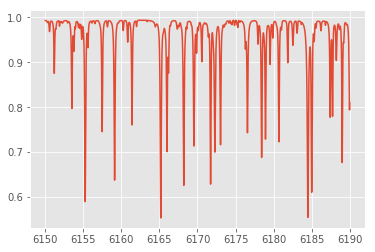

In [3]:
# Convenient way of passing multiple arguments in one class (similar to F.bla = bla in Matlab):
# Creating an empty class (won't go into full object oriented programming here though, just a dirty trick of misusing classes)
class Setup:
    pass
mySetup = Setup()

# Set some variables here:

# Just assuming something here for now:
mySetup.FWHM = 0.05
nu = sun[:,0]
# Just assuming something here for now:


# Try to restrict the forward model to a smaller range now:
wo = np.where((nu>6150)&(nu<6190))[0]
# Save wavenumber grid and cross section matrices just for the small range here:
mySetup.nu_in = nu[wo]
mySetup.detPixels = 1400
mySetup.Tsolar = sun[wo,1]

plt.plot(sun[wo,0], sun[wo,1])

In [4]:
# Import a Gaussian convolution
from scipy.ndimage.filters import gaussian_filter1d
# Import a 1D interpolation routine
from scipy.interpolate import interp1d

# write a separate function to just apply the instrument function (as we do this often:) 
# This could be more sophisticated than a Gaussian line-shape. 
# If we have it in a separate function, things can be easily replaced.
def applyInstrument(F,b):
    co = 2.355
    res = b.nu_in[1]-b.nu_in[0]
    F2 = gaussian_filter1d(F, b.FWHM/res/co)
    finter = interp1d(b.nu_in, F2,kind='linear', fill_value=np.NaN,bounds_error=False)
    return finter(b.nu_out)
    
def ForwardModel(x, b,compK=False):
    co = 2.355
    res = b.nu_in[1]-b.nu_in[0]
    
    poly_wl = x[0:3]
    poly = x[3:]
    
    grid = np.arange(0,b.detPixels,1)-b.detPixels/2.
    # Compute transmission
    T = b.Tsolar
    
    # Multiply with our baseline polynomial
    dnu = b.nu_in-np.mean(b.nu_in)
    F = T*np.polyval(poly, dnu)
    
    # Convolve Function
    F_conv = gaussian_filter1d(F, b.FWHM/res/co)
    
    # Generate a Spline interpolation function
    finter = interp1d(b.nu_in, F_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
    
    
    b.nu_out = np.polyval(poly_wl,grid)
    F_ref = finter(b.nu_out)
    # Compute Jacobian Matrix K if needed analytically here (will go through this in class):
    if compK:
        K = np.zeros((len(b.nu_out),len(x)))
        dx = [1e-10,0.00001,0.001]
        # This is now just a numerical derivative:
        for i in range(3):
            poly_wl2 = poly_wl.copy()
            poly_wl2[i] = poly_wl[i]+dx[i]
            FF = finter(np.polyval(poly_wl2,grid))
            K[:,i] = (FF-F_ref)/dx[i]
        #K[:,0]=1
        # Polynomials here:
        K[:,3]   = applyInstrument(T*dnu**2,b);
        K[:,3+1] = applyInstrument(T*dnu,b);
        K[:,3+2] = applyInstrument(T,b);
    if compK:
        return applyInstrument(F,b),K
    else:
        return applyInstrument(F,b)

### Defining the state vector $x$:
Simpler now, we just need polynomial coefficients for the baseline but also for the wavenumber grid, i.e. 6 parameters: 

In [5]:
# Now let us define the state vector x
x = np.zeros((6,))
x_true = np.zeros((6,))
# Last: The polynomial coefficients at the end of the state vector!
poly_wl = [0,0.0202,6167]
poly = [1e-7,-0.1,25]
x[0:3] = poly_wl
x[3:] = poly
x_true[3:] = poly
# Bad example for normal inversion, runaway solution here:
x_true[0:3] = [0,0.0194,6166.8]
# Good example (works)
#x_true[0:3] = [0,0.0201,6166.8]
xa = x

Add prior information

In [6]:
# Add prior information:
Sa = np.zeros((len(x),len(x)))

# For the polynomials
Sa[0,0]=1e-7**2.
Sa[1,1]=0.002**2.
Sa[2,2]=0.2**2.

# For the polynomials
Sa[3,3]=1e-3**2
Sa[4,4]=1e-2**2
Sa[5,5]=1**2

Define noise:

In [7]:
noise = 0.02

In [8]:
y = ForwardModel(x_true,mySetup)
y += np.random.randn(len(y))*noise

invSe = np.zeros((len(y),len(y)))
for i in np.arange(0,len(y),1):
   invSe[i,i]=1./(noise**2) 

### Let's run the forward model and Jacobian generation

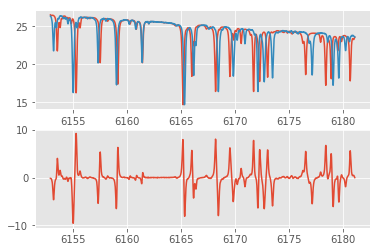

In [9]:
F0,K = ForwardModel(x,mySetup,True)


plt.subplot(211)
plt.plot(mySetup.nu_out, F0,mySetup.nu_out, y)
plt.subplot(212)
plt.plot(mySetup.nu_out, y-F0)

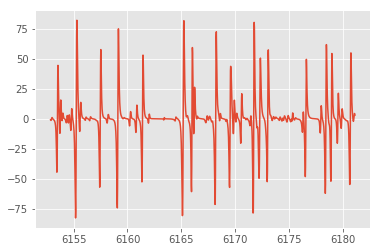

In [10]:
plt.plot(mySetup.nu_out, K[:,2])

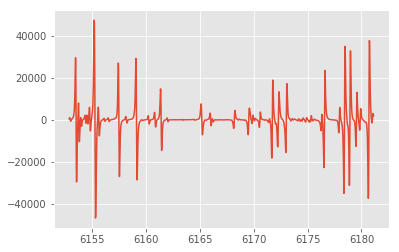

In [11]:
plt.plot(mySetup.nu_out, K[:,1])

Let us compute a cost function:

In [12]:
dx = np.arange(-0.5,0.5,0.008)
print(len(dx))
chi2 = np.zeros((len(dx),))
for i in range(len(dx)):
    xc = x.copy()
    xc[2] = x[2]+dx[i]
    F1 = ForwardModel(xc,mySetup)
    chi2[i] = np.sum((F1-F0)**2.)/len(F1)

125


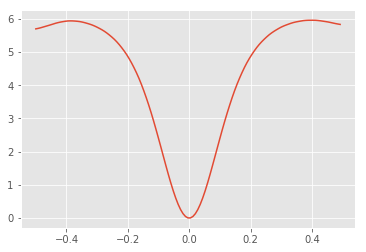

In [13]:
plt.plot(dx,chi2)

In [14]:
dxDisp = np.arange(-0.0012,0.0012,0.00002)
print(len(dxDisp))
chi2_Disp = np.zeros((len(dxDisp),))
for i in range(len(dxDisp)):
    xc = x.copy()
    xc[1] = x[1]+dxDisp[i]
   # print xc[1]
    F1 = ForwardModel(xc,mySetup)
    chi2_Disp[i] = np.sum((F1-F0)**2.)/len(F1)

120


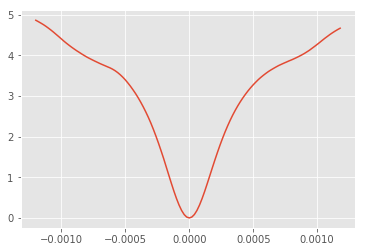

In [15]:
plt.plot(dxDisp,chi2_Disp)

In [16]:
chi2_all = np.zeros((len(dx),len(dxDisp)))
for i in range(len(dx)):
    xc = x.copy()
    xc[2] = x[2]+dx[i]
    for j in range(len(dxDisp)):
        xc[1]=x[1]+dxDisp[j]
        F1 = ForwardModel(xc,mySetup)
        chi2_all[i,j] = np.sum((F1-F0)**2.)/len(F1)

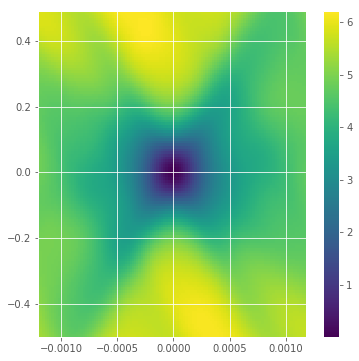

In [17]:
figsize(6,6)
plt.imshow(chi2_all, origin='lower',
           extent=[dxDisp.min(), dxDisp.max(), dx.min(), dx.max()],aspect='auto',cmap='viridis')
plt.colorbar()

In [18]:
max_no_of_iter = 61
x_all = np.zeros((len(xa),max_no_of_iter))
F_all = np.zeros((len(y),max_no_of_iter))
redChi2 = np.zeros((max_no_of_iter,))
# Set first state vector to the prior (doesn't have to be)
x_all[:,0]=xa

for i in range(max_no_of_iter-1):
    #print('Iteration #',i)
    Fi,Ki = ForwardModel(x_all[:,i],mySetup,True)
    Gain = np.linalg.inv(Ki.T.dot(invSe).dot(Ki)+np.linalg.inv(Sa)).dot(Ki.T).dot(invSe)
    x_all[:,i+1] = xa + Gain.dot(y-Fi+Ki.dot(x_all[:,i]-xa))
   # print(x_all[:,i+1]-x_true)
    redChi2[i] = ((y-Fi).T.dot(invSe).dot(y-Fi))/len(y)
    F_all[:,i] = Fi

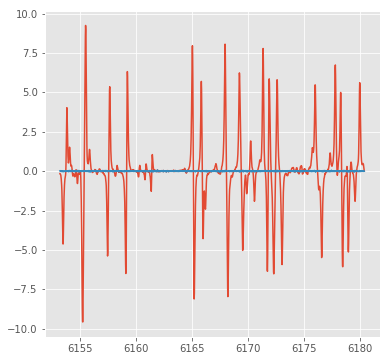

In [19]:
plt.plot(mySetup.nu_out, y-F_all[:,0],mySetup.nu_out, y-F_all[:,-2])

Text(0,0.5,'$\\Delta$ shift')

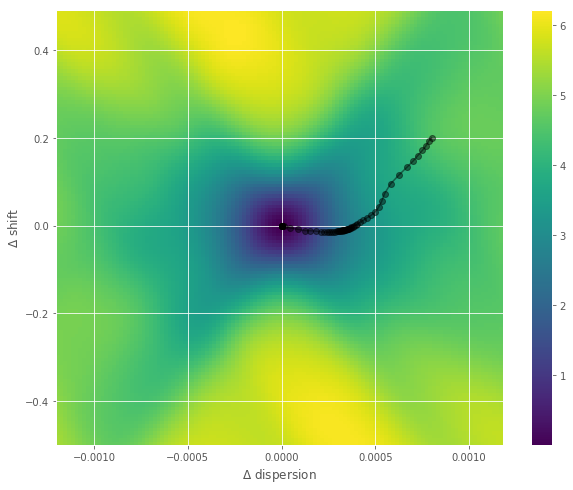

In [20]:
figsize(10,8)
r = 50
#r2 = 250
plt.imshow(chi2_all, origin='lower',
           extent=[dxDisp.min(), dxDisp.max(), dx.min(), dx.max()],aspect='auto',cmap='viridis')
plt.colorbar()
plt.plot(x_all[1,:]-x_true[1],x_all[2,:]-x_true[2],'ko-',alpha=0.45)
plt.xlabel('$\Delta$ dispersion')
plt.ylabel('$\Delta$ shift')

Text(0.5,0,'Iteration')

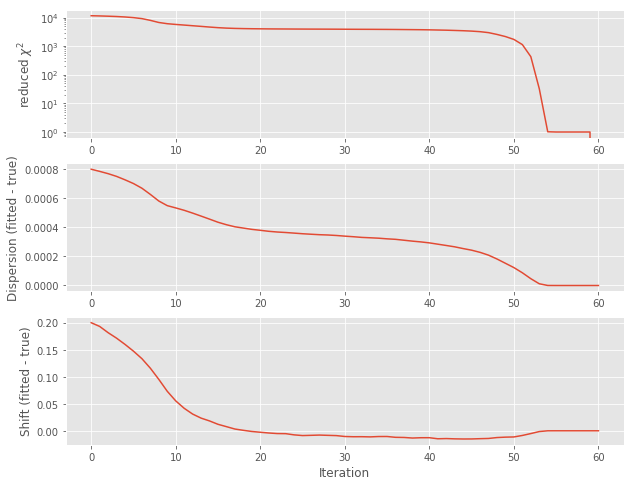

In [21]:
plt.subplot(311)
plt.semilogy(redChi2)
plt.ylabel('reduced $\chi^2$')
plt.subplot(312)
plt.plot(x_all[1,:]-x_true[1])
plt.ylabel('Dispersion (fitted - true)')
plt.subplot(313)
plt.plot(x_all[2,:]-x_true[2])
plt.ylabel('Shift (fitted - true)')
plt.xlabel('Iteration')

In [22]:
max_no_of_iter = 61
gamma = 5000000
x_all_levMar = np.zeros((len(xa),max_no_of_iter))
F_all_levMar = np.zeros((len(y),max_no_of_iter))
redChi2_levMar = np.zeros((max_no_of_iter,))
gamma_levMar = np.zeros((max_no_of_iter,))
# Set first state vector to the prior (doesn't have to be)
x_all_levMar[:,0]=xa

for i in range(max_no_of_iter-1):
    #    print('Iteration #',i)
    Fi,Ki = ForwardModel(x_all_levMar[:,i],mySetup,True)
    f1 = np.linalg.inv((1+gamma)*np.linalg.inv(Sa)+Ki.T.dot(invSe).dot(Ki))
    f2 = (Ki.T.dot(invSe).dot(y-Fi))-np.linalg.inv(Sa).dot(x_all_levMar[:,i]-xa)
    ddx = f1.dot(f2)
    x_all_levMar[:,i+1] = x_all_levMar[:,i]+ddx
    
    # Compute forward model here once more to test for non-linearities:
    Flev = ForwardModel(x_all_levMar[:,i+1],mySetup)
    # Chi2 from previous run:
    redChi2_levMar[i] = ((y-Fi).T.dot(invSe).dot(y-Fi))/len(y)
    chi2_true = ((y-Flev).T.dot(invSe).dot(y-Flev))/len(y)
    chi2_expected = ((y-Fi-Ki.dot(ddx)).T.dot(invSe).dot(y-Fi-Ki.dot(ddx)))/len(y)
  #  print('True  ', chi2_true)
  #  print('Expec ', chi2_expected)
    gamma_levMar[i] = gamma
    R = (redChi2_levMar[i]-chi2_true)/(redChi2_levMar[i]-chi2_expected)
    if R>0.75 or (redChi2_levMar[i]-chi2_true)<0.02:
        gamma/=2.
    elif R<0.25:
        gamma*=10.
        # Don't update state vector (set back to previous one):
        x_all_levMar[:,i+1] = x_all_levMar[:,i]
 #   print R, gamma
 #   print(x_all_levMar[:,i+1]-x_true)
    redChi2_levMar[i] = ((y-Fi).T.dot(invSe).dot(y-Fi))/len(y)
    F_all_levMar[:,i] = Fi

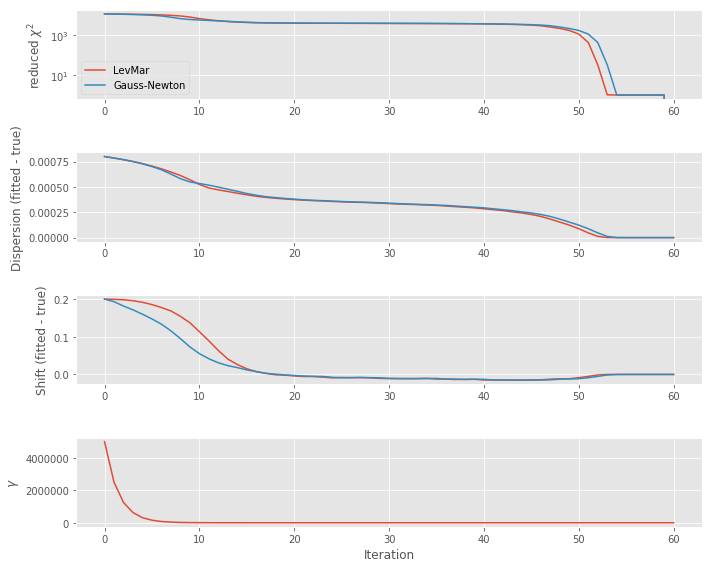

In [23]:
plt.subplot(411)
plt.semilogy(np.arange(0,max_no_of_iter,1),redChi2_levMar,label='LevMar')
plt.semilogy(np.arange(0,max_no_of_iter,1),redChi2,label='Gauss-Newton')
plt.ylabel('reduced $\chi^2$')
plt.legend()
plt.subplot(412)
plt.plot(x_all_levMar[1,:]-x_true[1])
plt.ylabel('Dispersion (fitted - true)')
plt.plot(x_all[1,:]-x_true[1])
plt.subplot(413)
plt.ylabel('Shift (fitted - true)')
plt.plot(x_all_levMar[2,:]-x_true[2])
plt.plot(x_all[2,:]-x_true[2])
plt.subplot(414)
plt.plot(gamma_levMar)
plt.ylabel('$\gamma$')
plt.xlabel('Iteration')
plt.tight_layout()

(125, 120)


Text(0.5,1,'$\\chi^2$ plane')

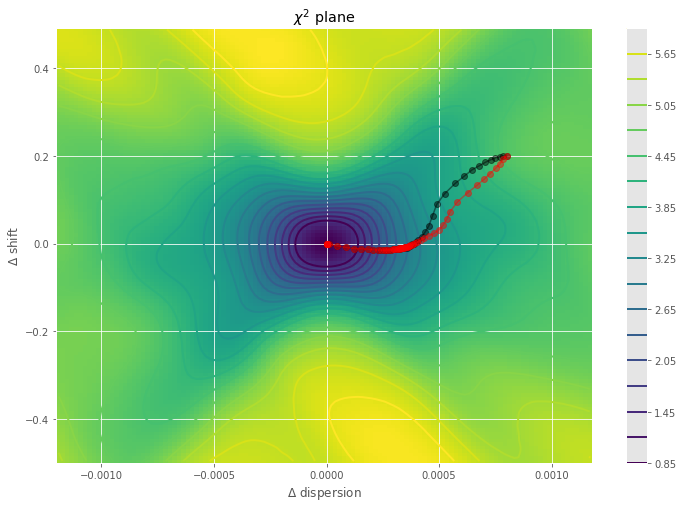

In [25]:
figsize(12,8)
print(chi2_all.shape)
r = 40
#r2 = 250
plt.imshow(chi2_all, origin='lower',
           extent=[dxDisp.min(), dxDisp.max(), dx.min(), dx.max()],aspect='auto',cmap='viridis')
levels = np.arange(0.85, 6, 0.3)
CS = plt.contour(chi2_all, levels,
                 origin='lower',
                 linewidths=2,
                 cmap='viridis',
                 extent=[dxDisp.min(), dxDisp.max(), dx.min(), dx.max()])

plt.colorbar()
plt.plot(x_all_levMar[1,:]-x_true[1],x_all_levMar[2,:]-x_true[2],'ko-',alpha=0.45)
plt.plot(x_all[1,:]-x_true[1],x_all[2,:]-x_true[2],'ro-',alpha=0.45)
plt.xlabel('$\Delta$ dispersion')
plt.ylabel('$\Delta$ shift')
plt.title('$\chi^2$ plane')